In [ ]:
import scipy
import scipy.sparse.linalg
import scipy.interpolate
from itertools import product
from math import *
import numpy as np
import scipy.sparse
import matplotlib.pyplot as plt
#compute_abc, compute_W(a,b,c, V0, VM), compute_W(a,b,c, V0, VM) are based on John.Armstrong's lecture notes
#https://keats.kcl.ac.uk/course/view.php?id=93365
def bottom_boundary_condition( K, T, S_min, r, t):
    return np.ones(t.shape)*K

def top_boundary_condition( K, T, S_max, r, t):
    return np.maximum(K-S_max,0)

def final_boundary_condition( K, T, S ):
    return np.maximum(K-S,0)

def compute_abc( K, T, sigma, r, S, dt, dS, beta ):
    a = -sigma**2 * S**(2*beta)/(2* dS**2 ) + r*S/(2*dS)
    b = r + sigma**2 * S**(2*beta)/(dS**2)
    c = -sigma**2 * S**(2*beta)/(2* dS**2 ) - r*S/(2*dS)
    return a,b,c

def compute_lambda( a,b,c ):
    return scipy.sparse.diags( [a[1:],b,c[:-1]],offsets=[-1,0,1],format='csr')

def compute_W(a,b,c, V0, VM):
    M = len(b)+1
    W = np.zeros(M-1)
    W[0] = a[0]*V0
    W[-1] = c[-1]*VM
    return W
#based on John.Armstrong's lecture notes
#https://keats.kcl.ac.uk/course/view.php?id=93365
def price_put_crank_nicolson( K, T, r, sigma, N, M, beta, S_min, S_max,typeofoption="American"):
    dt = T/N
    dS = (S_max-S_min)/M
    S = np.linspace(S_min,S_max,M+1)
    t = np.linspace(0,T,N+1)
    V = np.zeros((N+1,M+1)) #...
    B=np.zeros(N)
    V[:,-1] = top_boundary_condition(K,T,S_max,r,t)
    V[:,0] = bottom_boundary_condition(K,T,S_max,r,t)
    V[-1,:] = final_boundary_condition(K,T,S)
    a,b,c = compute_abc(K,T,sigma,r,S[1:-1],dt,dS,beta)
    Lambda =compute_lambda(a,b,c) #...
    identity = scipy.sparse.identity(M-1)
    for i in range(N-1,-1,-1):
        Wt = compute_W(a,b,c,V[i,0],V[i,M])
        Wt_plus_dt = compute_W(a,b,c,V[i+1,0],V[i+1,M])
        if typeofoption=='American':
            V[i,1:M] = np.maximum(scipy.sparse.linalg.spsolve(identity+0.5*Lambda*dt,(identity-0.5*Lambda*dt).dot(V[i+1,1:M]) -0.5*dt*(Wt_plus_dt + Wt)),K-S[1:M])
            sign=(V[i-1,1:M]-(K-S[1:M]))>0
            for j in range(M-1):
                if sign[j]==True:
                    B[i-1]=(j+1)*dS+S_min
                    break
        elif typeofoption=='European':
            V[i,1:M] = scipy.sparse.linalg.spsolve(identity+0.5*Lambda*dt,(identity-0.5*Lambda*dt).dot(V[i+1,1:M]) -0.5*dt*(Wt_plus_dt + Wt))
        else:
            print('please enter a type from American or European')
    return V, t, S


###interpolation function
def findprice(S0,TTM,V,S_max,Tmax,N,M):
    col=S0/(S_max/M)
    row=(Tmax-TTM)/(Tmax/N)
    upcol=ceil(col)
    downcol=floor(col)
    uprow=ceil(row)
    downrow=floor(row)
    if (col-int(col))<0.1 and (row-int(row))>0.1:
        f1=scipy.interpolate.interp1d(np.array([downrow,uprow]), np.array([V[downrow,int(col)],V[uprow,int(col)]]))
        P=f1(row)
    elif (col-int(col))>0.1 and (row-int(row))<0.1:
        f2=scipy.interpolate.interp1d(np.array([downcol,upcol]), np.array([V[int(row),downcol],V[int(row),upcol]]))
        P=f2(col)
    elif (col-int(col))<0.1 and (row-int(row))<0.1:
        P=(V[int(row),int(col)])
    else:
        f3=scipy.interpolate.interp2d(np.array([downrow,uprow]),np.array([downcol,upcol]),np.array([[V[downrow,downcol],V[downrow,upcol]],[V[uprow,downcol],V[uprow,upcol]]]))
        P=f3(row,col)
    return float(P)
#based on John.Armstrong's lecture notes
#https://keats.kcl.ac.uk/course/view.php?id=93365
def price_put_explicit( K, T, r, sigma, N, M, beta, S_min, S_max):
    # Choose the shape of the grid
    dt = T/N
    dS = (S_max-S_min)/M
    S = np.linspace(S_min,S_max,M+1)
    t = np.linspace(0,T,N+1)
    V = np.zeros((N+1,M+1)) #...
    B=np.zeros(N)
    # Set the boundary conditions
    V[:,-1] = top_boundary_condition(K,T,S_max,r,t)
    V[:,0] = bottom_boundary_condition(K,T,S_max,r,t)
    V[-1,:] = final_boundary_condition(K,T,S) #...
    # Apply the recurrence relation
    a,b,c = compute_abc(K,T,sigma,r,S[1:-1],dt,dS,beta)
    Lambda =compute_lambda( a,b,c)
    identity = scipy.sparse.identity(M-1, format='csr')
    for i in range(N,0,-1):
        W = compute_W(a,b,c,V[i,0],V[i,M])
        # Use `dot` to multiply a vector by a sparse matrix
        V[i-1,1:M] = np.maximum((identity-Lambda*dt).dot( V[i,1:M] ) - W*dt, K-S[1:M])
        sign=(V[i-1,1:M]-(K-S[1:M]))>0
        for j in range(M-1):
            if sign[j]==True:
                B[i-1]=(j+1)*dS+S_min
                break
    return V, t, S,B
#based on John.Armstrong's lecture notes
#https://keats.kcl.ac.uk/course/view.php?id=93365
def plot_option_price(V,t,S):
    M = len(S)-1
    S_zoom = S[0:int(M)]
    V_zoom=V[:,0:int(M)]
    t_mesh, S_mesh = np.meshgrid(t,S_zoom)
    ax = plt.axes(projection='3d')
    ax.plot_surface(t_mesh,S_mesh,V_zoom.T, alpha=0.3,edgecolor='k');
    ax.set_xlabel('Time (t)')
    ax.set_ylabel('Stock price (S)')
    ax.set_zlabel('Option price')


In [ ]:

def norm2(x,y):
    d=0
    for i in range(x.size):
        d=d+(x[i]-y[i])**2
    return d
##SOR method for solving a system of linear equations
def SOR(A,b,x,e,w,times):
    D=np.array(np.diag(np.diag(A)))
    L=np.triu(A,1)
    U=np.tril(A,-1)
    Sw=np.linalg.inv(D+w*L)@((1-w)*D-w*U)
    fw=w*(np.linalg.inv(D+w*L))@(b.T)
    x0=x
    x=Sw@x0.T+fw
    k=1
    while k< times:
        if norm2(x,x0)>e:
            x0=x
            x=Sw@x0.T+fw
            k=k+1
        else:
            break
    return x
def compute_lambda1( a,b,c ):
    array_a=np.diag(b)
    array=np.diag(a[1:])
    array1=np.diag(c[:-1])
    array_b=np.insert(array,0,values=np.zeros(b.size-1),axis=0)
    array_b=np.insert(array_b,b.size-1,values=np.zeros(b.size),axis=1)
    array_c=np.insert(array1,b.size-1,values=np.zeros(b.size-1),axis=0)
    array_c=np.insert(array_c,0,values=np.zeros(b.size),axis=1)
    matrix=array_a+array_b+array_c
    return matrix
def price_put_crank_nicolson_SOR( K, T, r, sigma, N, M, beta):
    x=np.zeros(M-1)
    e=pow(10,-6)
    times=100
    w=1
    dt = T/N
    S_min=0
    S_max=2
    dS = (S_max-S_min)/M
    S = np.linspace(S_min,S_max,M+1)
    t = np.linspace(0,T,N+1)
    V = np.zeros((N+1,M+1)) #...
    B=np.zeros(N)
    V[:,-1] = top_boundary_condition(K,T,S_max,r,t)
    V[:,0] = bottom_boundary_condition(K,T,S_max,r,t)
    V[-1,:] = final_boundary_condition(K,T,S)
    a,b,c = compute_abc(K,T,sigma,r,S[1:-1],dt,dS,beta)
    Lambda =compute_lambda1( a,b,c) #...
    QWE=np.ones(M-1)
    identity = np.diag(QWE)
    for i in range(N-1,-1,-1):
        Wt = compute_W(a,b,c,V[i,0],V[i,M])
        Wt_plus_dt = compute_W(a,b,c,V[i+1,0],V[i+1,M])
        V[i,1:M] = np.maximum(SOR((identity+0.5*Lambda*dt),(identity-0.5*Lambda*dt).dot(V[i+1,1:M]) -0.5*dt*(Wt_plus_dt + Wt),x,e,w,times),K-S[1:M])
        sign=(V[i-1,1:M]-(K-S[1:M]))>0
        for j in range(M-1):
            if sign[j]==True:
                B[i-1]=(j+1)*dS+S_min
                break
    return V, t, S,B


In [ ]:
#Use this to run SOR method
V, t, S=price_put_crank_nicolson(0.95, 1, 0.02, 0.2, 1000, 100, 1, 0, 2, 'American')
print(V[0,50])
V, t, S,B= price_put_crank_nicolson_SOR( 0.95, 1, 0.02, 0.2, 1000, 100, 1)
print(V[0,50])
del V
del t
del S
del B

0.04835745341940862
0.04783471808633215


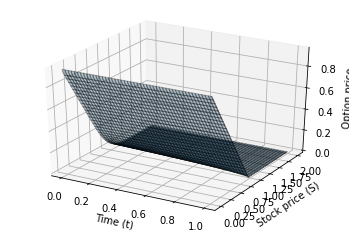

In [ ]:
#Plot European put price surface
V2, t2, S2=price_put_crank_nicolson(0.95, 1, 0.02, 0.2, 800, 400, 0.7,0,2,'European')
V, t, S,B=price_put_explicit( 0.95, 1, 0.02, 0.2, 10000, 400, 0.7,0,2)
plot_option_price(V2,t2,S2)


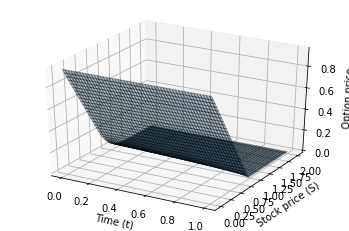

In [ ]:
#Plot American put price surface
plot_option_price(V,t,S)

In [ ]:
#test for fdm
def montecarlotest(S,T,K,N,M,r,sigma,gamma):
    A=np.zeros((N+1,M+1))
    A[:,0]=S
    dt=T/M
    for i in range(1,M+1):
        dW=np.random.randn(N+1)*(dt**0.5)
        A[:,i]=A[:,i-1]+r*A[:,i-1]*dt+sigma*(A[:,i-1]**gamma)*(dW.T)
    return np.maximum((K-A[:,M]),0).mean()*np.exp(-r*T)
print(montecarlotest(1.2,1,0.95,100000,100,0.02,0.2,0.7))
print(V[0,240])

0.00955597394255625
0.009670418153185721


0.6950000000000001


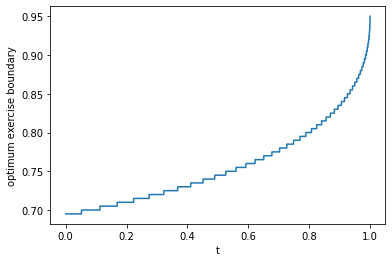

In [ ]:
##plot exercise boundary
plt.plot(t[0:10000],B)
plt.xlabel("t")
plt.ylabel("optimum exercise boundary")
print(B[0])

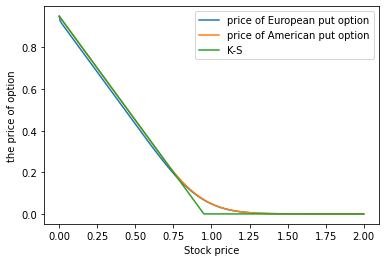

In [ ]:
#plot 2D prices
plt.plot(S[0:401],V2[0,:],label='price of European put option')
plt.plot(S[0:401],V[0,:],label='price of American put option')
plt.plot(S[0:401],np.maximum(0.95-S,0),label='K-S')
plt.xlabel("Stock price")
plt.ylabel("the price of option")
plt.legend('A fan diagram of geometric Brownian motion')
plt.legend()

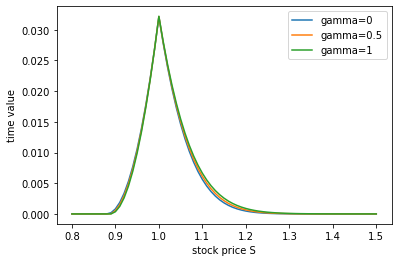

In [ ]:
#setting parameters and plot time value of fdm
ss=np.linspace(0.7,1.3,61)
sslow=np.linspace(0.5,0.7,21)
ssup=np.linspace(1.3,1.9,21)
ss=np.concatenate((ss,sslow))
ss=np.concatenate((ss,ssup))
tt=np.linspace(0,2,41)
S_min=0
S_max=3
T=2
Tmax=2
N=2000
M=300
fixK=1
fixsigma=0.15
K=1
r=0.02
sigma=0.1
gamma0=0
gamma05=0.5
gamma1=1
SS0=np.linspace(0.8,1.5,71)
V00, t00, S00= price_put_crank_nicolson(  K, T, r, sigma, N, M, gamma0, S_min, S_max,typeofoption="American")
V05, t05, S05= price_put_crank_nicolson(  K, T, r, sigma, N, M, gamma05, S_min, S_max,typeofoption="American")
V10, t10, S10= price_put_crank_nicolson(  K, T, r, sigma, N, M, gamma1, S_min, S_max,typeofoption="American")
FD=np.zeros((3,71))
for i in range(71):
  FD[0,i]=findprice(SS0[i],1,V00,S_max,Tmax,N,M)
  FD[1,i]=findprice(SS0[i],1,V05,S_max,Tmax,N,M)
  FD[2,i]=findprice(SS0[i],1,V10,S_max,Tmax,N,M)
plt.plot(SS0,FD[0,:]-np.maximum(1-SS0,0),label='gamma=0')
plt.plot(SS0,FD[1,:]-np.maximum(1-SS0,0),label='gamma=0.5')
plt.plot(SS0,FD[2,:]-np.maximum(1-SS0,0),label='gamma=1')
plt.xlabel('stock price S')
plt.ylabel('time value')
plt.legend()

In [ ]:
#creating dataset: don't run this page if you don't need to create dataset but use downloaded one.
def createdata(ss,tt,n):
  with open('data.txt',"w") as f:
    rr=np.linspace(0,0.15,n)
    ggmama=np.linspace(0,1,n)
    for i in range(n):
      for j in range(n):
        r=rr[i]
        gamma=ggmama[j]
        V, t, S= price_put_crank_nicolson( fixK, T, r, fixsigma, N, M, gamma, S_min, S_max,typeofoption="American")
        print(i,j)
        for p in range(ss.shape[0]):
          s=ss[p]
          for q in range(tt.shape[0]):
            t=tt[q]
            print(s,t,r,gamma,findprice(s,t,V,S_max,Tmax,N,M),file=f)
    f.close()
    return 0
createdata(ss,tt,20)
with open('data.txt',"r") as f:
  validdata = np.loadtxt(f)

In [ ]:
#if you have already downloaded a dataset, run first two commands
with open('datanew.txt',"r") as f:
  validdata = np.loadtxt(f)


#delete some samples with extreme small price.
count=0
for i in range(validdata.shape[0]):
  if validdata[i,4]>0.00001:
    count=count+1
validdata1=np.zeros((count,5))
row=0
for k in range(validdata.shape[0]):
  if validdata[k,4]>0.00001:
    validdata1[row,:]=validdata[k,:]
    row=row+1
print(count)


1412417


In [ ]:
#scale the dataset
#scale method 2
xx=validdata1[:,0:4]
yy=validdata1[:,4]
print(yy.shape)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    xx, yy, test_size=0.1, random_state=42)

x_train_transform=np.zeros((X_train.shape[0],X_train.shape[1]))
x_test_transform=np.zeros((X_test.shape[0],X_test.shape[1]))
for i in range(4):
    x_train_transform[:,i]=(2*X_train[:,i]-(X_train[:,i].max()-X_train[:,i].min()))/(X_train[:,i].max()-X_train[:,i].min())
    x_test_transform[:,i]=(2*X_test[:,i]-(X_test[:,i].max()-X_test[:,i].min()))/(X_test[:,i].max()-X_test[:,i].min())
y_train_transform=(2*y_train-(y_train.max()-y_train.min()))/(y_train.max()-y_train.min())
y_test_transform=(2*y_test-(y_test.max()-y_test.min()))/(y_test.max()-y_test.min())

(1412417,)


In [ ]:
#construct the loss function
def ziweifunction(y_true,y_predict):
    if y_true<0.01:
        a=(abs(y_true-y_predict)/y_true)/5
    else:
        a=abs(y_true-y_predict)
    return a
def ziweifunction2(y_true,y_predict):
    a=abs((y_true-y_predict)/y_true+0.0001)*100
    return a
def newpercent(y_true,y_predict):
    a=log(abs((y_true-y_predict**2)))
    return a
from keras import backend as K
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))

In [ ]:
#training the neural network. Change epochs to 100 to improve accuracy
import tensorflow.keras as keras
g_hat = keras.Sequential([
    keras.layers.Dense(30, activation="elu", input_shape=(4,)),
    keras.layers.Dense(30, activation="elu"),
    keras.layers.Dense(30, activation="elu"),
    keras.layers.Dense(30, activation="elu"),
    keras.layers.Dense(1, activation="linear")
]
)
g_hat.summary()
g_hat.compile(optimizer="adam", loss=root_mean_squared_error)
g_hat.fit(x_train_transform, y_train_transform, batch_size=80, epochs=70,validation_data = (x_test_transform,y_test_transform))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 30)                150       
                                                                 
 dense_1 (Dense)             (None, 30)                930       
                                                                 
 dense_2 (Dense)             (None, 30)                930       
                                                                 
 dense_3 (Dense)             (None, 30)                930       
                                                                 
 dense_4 (Dense)             (None, 1)                 31        
                                                                 
Total params: 2,971
Trainable params: 2,971
Non-trainable params: 0
_________________________________________________________________
Epoch 1/70
15890/15890 [==============================

In [ ]:
#scaling relationship function
def scalingfunction(a,b,c,d,e,f,K,sigma):
    lamb=b/K
    S0=a/lamb
    gamma=f
    alpha=(((lamb**(1-gamma))*sigma)/e)**2
    r=d*alpha
    T=c/alpha
    return np.array((S0,T,r,gamma)),lamb
#get predictions
ans1,lamb1=scalingfunction(1.1,1,1,0.05,0.1,0.9,1,0.15)
ans2,lamb2=scalingfunction(1,1,1,0.05,0.1,0.9,1,0.15)
ans3,lamb3=scalingfunction(0.9,1,0.5,0.02,0.1,0.5,1,0.15)
ans4,lamb4=scalingfunction(2.6,2,1,0.1,0.2,0.8,1,0.15)
A=np.array([ans1,ans2,ans3,ans4])
for i in range(4):
    A[:,i]=(2*A[:,i]-(X_train[:,i].max()-X_train[:,i].min()))/(X_train[:,i].max()-X_train[:,i].min())
prediction=(g_hat.predict(A)*(y_train.max()-y_train.min())+(y_train.max()-y_train.min()))/2
print(prediction[0]*lamb1,prediction[1]*lamb2,prediction[2]*lamb3,prediction[3]*lamb4)

[0.00388429] [0.02433939] [0.10014172] [0.00256228]


In [ ]:
#FDM value
V9,t9,s9=price_put_crank_nicolson( 1, T, 0.05, 0.1, N, M, 0.9, S_min, S_max,typeofoption="American")
V10,t10,s10=price_put_crank_nicolson( 1, T, 0.02, 0.1, N, M, 0.5, S_min, S_max,typeofoption="American")
V11,t11,s11=price_put_crank_nicolson( 2, T, 0.1, 0.2, N, M, 0.8, S_min, S_max,typeofoption="American")
print(findprice(1.1,1,V9,S_max,Tmax,N,M),findprice(1,1,V9,S_max,Tmax,N,M),findprice(0.9,0.5,V10,S_max,Tmax,N,M),findprice(2.6,1,V11,S_max,Tmax,N,M))

0.003739863919322287 0.024278618567804368 0.09999999999999998 0.002443116884701212


0.0038842885336169974 0.024339390941465755 0.1001417219032214 0.0025622908731434135


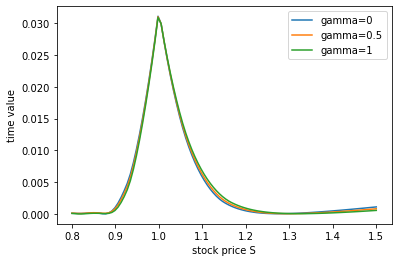

In [ ]:
#plot time value of neural network
def NN_CEV(S0,K,T,r,sigma,gamma,fixK,fixsigma):
  para,lamb=scalingfunction(S0,K,T,r,sigma,gamma,fixK,fixsigma)
  for i in range(4):
    para[i]=(2*para[i]-(X_train[:,i].max()-X_train[:,i].min()))/(X_train[:,i].max()-X_train[:,i].min())
  prediction=g_hat.predict(np.array([para]))[0][0]
  prediction=(prediction*(y_train.max()-y_train.min())+(y_train.max()-y_train.min()))/2
  prediction=prediction*lamb
  return prediction
print(NN_CEV(1.1,1,1,0.05,0.1,0.9,fixK,fixsigma),NN_CEV(1,1,1,0.05,0.1,0.9,fixK,fixsigma),NN_CEV(0.9,1,0.5,0.02,0.1,0.5,fixK,fixsigma),NN_CEV(2.6,2,1,0.1,0.2,0.8,fixK,fixsigma))
SS0=np.linspace(0.8,1.5,100)
pred0=np.zeros((3,100))
for i in range(100):
  pred0[0,i]=NN_CEV(SS0[i],1,1,0.02,0.1,0,fixK,fixsigma)
  pred0[1,i]=NN_CEV(SS0[i],1,1,0.02,0.1,0.5,fixK,fixsigma)
  pred0[2,i]=NN_CEV(SS0[i],1,1,0.02,0.1,1,fixK,fixsigma)
plt.plot(SS0,pred0[0,:]-np.maximum(1-SS0,0),label='gamma=0')
plt.plot(SS0,pred0[1,:]-np.maximum(1-SS0,0),label='gamma=0.5')
plt.plot(SS0,pred0[2,:]-np.maximum(1-SS0,0),label='gamma=1')
plt.xlabel('stock price S')
plt.ylabel('time value')
plt.legend()

Text(0, 0.5, 'S0')

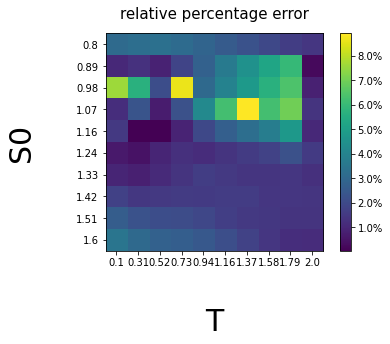

In [ ]:
#showing effectiveness
import gzip
import pandas as pd
import numpy as np
import matplotlib.ticker as mtick
import csv
SS0=np.linspace(0.8,1.6,10)
TT=np.linspace(0.1,2,10)
r=0.02
K=1
def NN_prices(SS0,K,TT,r,sigma,gamma):
  prices=np.zeros((SS0.shape[0],TT.shape[0]))
  for i in range(SS0.shape[0]):
    for j in range(TT.shape[0]):
      prices[i,j]=NN_CEV(SS0[i],K,TT[j],r,sigma,gamma,fixK,fixsigma)
  return prices
def FDM_prices(SS0,TT,V):
  prices0=np.zeros((SS0.shape[0],TT.shape[0]))
  for i in range(SS0.shape[0]):
    for j in range(TT.shape[0]):
      prices0[i,j]=findprice(SS0[i],TT[j],V,S_max,Tmax,N,M)
  return prices0
def rela(prices,prices0):
  rela=np.zeros((prices.shape[0],prices.shape[1]))
  for i in range(prices.shape[0]):
    for j in range(prices.shape[1]):
      if abs(prices[i,j]-prices0[i,j])<0.001:
        rela[i,j]=abs(prices[i,j]-prices0[i,j])*100
      else:
        rela[i,j]=abs(prices[i,j]-prices0[i,j])/(prices0[i,j])
  return rela
prices=NN_prices(SS0,K,TT,r,sigma,gamma1)
prices0=FDM_prices(SS0,TT,V10)
rela1=rela(prices,prices0)
ax=plt.subplot(1,1,1)
plt.title("relative percentage error",fontsize=15,y=1.04)
plt.imshow(rela1*100)
plt.colorbar(format=mtick.PercentFormatter())
ax.set_xticks(np.linspace(0,len(TT)-1,len(TT)))
ax.set_xticklabels(np.round(TT,2))
ax.set_yticks(np.linspace(0,len(SS0)-1,len(SS0)))
ax.set_yticklabels(np.round(SS0,2))
plt.xlabel("T",fontsize=30,labelpad=40)
plt.ylabel("S0",fontsize=30,labelpad=40)



# 新段落

# 新段落